In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:100% !important;}
div.cell.code_cell.rendered{width:100%;}
div.input_prompt{padding:0px;}
div.CodeMirror {font-family:Consolas; font-size:14pt;}
div.text_cell_render.rendered_html{font-size:14pt;}
div.text_cell_render ul li, code{font-size:22pt; line-height:14px;}
div.output {font-size:14pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:14pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:14pt;padding:5px;}
table.dataframe{font-size:14px;}
</style>
"""))

# <span style="color:red">ch7_Attention(스마트번역기)</span>
- Google Neural Machine Translation(GNMT)
- RNN기반의 Sequence to Sequence 방식
- 인코더(입력) / 디코더(모범출력) 연결구조
- 응용분야 : 자연어                                         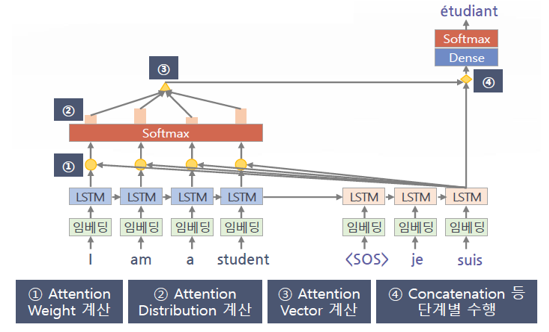

# 1. 패키지 및 하이퍼 파라미터

In [2]:
import numpy as np
import pandas as pd
from time import time
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

# 하이퍼파라미터
MY_HIDDEN = 128
MY_EPOCH  = 500

# 2. 학습 데이터

In [10]:
raw = pd.read_csv('data/translate.csv', header=None)
eng_kor = raw.values.tolist()   # 데이터프레임을 list로 변환
print(eng_kor[:3])
print('영-한 번역 데이터 갯수 : ', len(eng_kor))

[['cold', '감기'], ['come', '오다'], ['cook', '요리']]
영-한 번역 데이터 갯수 :  110


# 3. 영어알파벳과 한글문자 리스트 만들기

In [11]:
e_alpha = [c for c in 'SEPabcdefghijklmnopqrstuvwxyz']
korean = ''.join([data[1] for data in eng_kor])
k_ch = list(set([ch for ch in korean]))
#k_ch.sort()

k_alpha = pd.read_csv('data/korean.csv', header=None)[0].tolist()
k_alpha == k_ch  # 순서와 내용이 같은지 여부

False

In [24]:
from collections import Counter  
list1 = ['가','나','다']
list2 = ['다','가','나']
print(list1==list2)    # 순서까지 똑같은지
print(Counter(list1)==Counter(list2))  # 순서가 달라도 같은지

False
True


In [12]:
alpha = e_alpha + k_alpha
print('영어와 한글 알파벳:', alpha)
alpha_total_size = len(alpha)  # 171(원핫인코딩 사이즈)
print('전체 알파벳 갯수(원핫인코딩 사이즈):', alpha_total_size)

영어와 한글 알파벳: ['S', 'E', 'P', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '가', '각', '간', '감', '개', '거', '것', '게', '계', '고', '관', '광', '구', '굴', '규', '그', '금', '기', '깊', '나', '날', '남', '내', '넓', '녀', '노', '놀', '농', '높', '뉴', '늦', '다', '단', '도', '동', '들', '람', '랑', '래', '램', '류', '름', '릎', '리', '많', '망', '매', '머', '먼', '멍', '메', '명', '모', '목', '무', '물', '미', '바', '반', '방', '번', '복', '부', '분', '붕', '비', '뿌', '사', '상', '색', '생', '서', '선', '소', '손', '수', '쉽', '스', '시', '식', '실', '싸', '아', '약', '얇', '어', '언', '얼', '여', '연', '오', '옥', '왼', '요', '용', '우', '운', '움', '위', '유', '은', '을', '음', '의', '이', '익', '인', '읽', '입', '자', '작', '장', '적', '제', '좋', '주', '지', '짜', '쪽', '찾', '책', '출', '칙', '크', '키', '탈', '택', '통', '파', '팔', '편', '피', '핑', '한', '합', '해', '행', '험', '회', '획', '휴', '흐']
전체 알파벳 갯수(원핫인코딩 사이즈): 171


# 4. 문자당 num를 갖는 dict

In [13]:
char_to_num = {}
for i, c in enumerate(alpha):
    #print(i,c)
    char_to_num[c] = i
print(char_to_num)

{'S': 0, 'E': 1, 'P': 2, 'a': 3, 'b': 4, 'c': 5, 'd': 6, 'e': 7, 'f': 8, 'g': 9, 'h': 10, 'i': 11, 'j': 12, 'k': 13, 'l': 14, 'm': 15, 'n': 16, 'o': 17, 'p': 18, 'q': 19, 'r': 20, 's': 21, 't': 22, 'u': 23, 'v': 24, 'w': 25, 'x': 26, 'y': 27, 'z': 28, '가': 29, '각': 30, '간': 31, '감': 32, '개': 33, '거': 34, '것': 35, '게': 36, '계': 37, '고': 38, '관': 39, '광': 40, '구': 41, '굴': 42, '규': 43, '그': 44, '금': 45, '기': 46, '깊': 47, '나': 48, '날': 49, '남': 50, '내': 51, '넓': 52, '녀': 53, '노': 54, '놀': 55, '농': 56, '높': 57, '뉴': 58, '늦': 59, '다': 60, '단': 61, '도': 62, '동': 63, '들': 64, '람': 65, '랑': 66, '래': 67, '램': 68, '류': 69, '름': 70, '릎': 71, '리': 72, '많': 73, '망': 74, '매': 75, '머': 76, '먼': 77, '멍': 78, '메': 79, '명': 80, '모': 81, '목': 82, '무': 83, '물': 84, '미': 85, '바': 86, '반': 87, '방': 88, '번': 89, '복': 90, '부': 91, '분': 92, '붕': 93, '비': 94, '뿌': 95, '사': 96, '상': 97, '색': 98, '생': 99, '서': 100, '선': 101, '소': 102, '손': 103, '수': 104, '쉽': 105, '스': 106, '시': 107, '식': 108, '실': 109, '싸': 110,

In [9]:
char_to_num = { c:i for i, c in enumerate(alpha)}
print(char_to_num)

{'S': 0, 'E': 1, 'P': 2, 'a': 3, 'b': 4, 'c': 5, 'd': 6, 'e': 7, 'f': 8, 'g': 9, 'h': 10, 'i': 11, 'j': 12, 'k': 13, 'l': 14, 'm': 15, 'n': 16, 'o': 17, 'p': 18, 'q': 19, 'r': 20, 's': 21, 't': 22, 'u': 23, 'v': 24, 'w': 25, 'x': 26, 'y': 27, 'z': 28, '가': 29, '각': 30, '간': 31, '감': 32, '개': 33, '거': 34, '것': 35, '게': 36, '계': 37, '고': 38, '관': 39, '광': 40, '구': 41, '굴': 42, '규': 43, '그': 44, '금': 45, '기': 46, '깊': 47, '나': 48, '날': 49, '남': 50, '내': 51, '넓': 52, '녀': 53, '노': 54, '놀': 55, '농': 56, '높': 57, '뉴': 58, '늦': 59, '다': 60, '단': 61, '도': 62, '동': 63, '들': 64, '람': 65, '랑': 66, '래': 67, '램': 68, '류': 69, '름': 70, '릎': 71, '리': 72, '많': 73, '망': 74, '매': 75, '머': 76, '먼': 77, '멍': 78, '메': 79, '명': 80, '모': 81, '목': 82, '무': 83, '물': 84, '미': 85, '바': 86, '반': 87, '방': 88, '번': 89, '복': 90, '부': 91, '분': 92, '붕': 93, '비': 94, '뿌': 95, '사': 96, '상': 97, '색': 98, '생': 99, '서': 100, '선': 101, '소': 102, '손': 103, '수': 104, '쉽': 105, '스': 106, '시': 107, '식': 108, '실': 109, '싸': 110,

In [10]:
# 숫자 -> 문자 / 문자 -> 숫자
print('수->문 :', alpha[5])
print('문->수 :', char_to_num['c'])

수->문 : c
문->수 : 5


In [11]:
data = eng_kor[0]
print(data)
# char_to_num['c'],char_to_num['o'],char_to_num['l'],char_to_num['d']
print('인코더 입력:', [char_to_num[ch] for ch in data[0]])
print('디코더 입력:', [char_to_num[ch] for ch in 'S'+data[1]])
print('디코더 출력:', [char_to_num[ch] for ch in data[1]+'E'])

['cold', '감기']
인코더 입력: [5, 17, 14, 6]
디코더 입력: [0, 32, 46]
디코더 출력: [32, 46, 1]


In [12]:
# 원핫인코딩 방법1: pd.get_dummies([5, 3, 7]) - 이코드에서는 적용 불가
pd.get_dummies([5, 3, 7])

,3,5,7
0,0,1,0
1,1,0,0
2,0,0,1


In [13]:
# 원핫인코딩 방법2: to_categorical([5,3,7], num_classes=10)
to_categorical([5,3,7], num_classes=10)

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]], dtype=float32)

In [14]:
# 원핫인코딩 방법3: np.eye(10)
np.eye(10)[[5,3,7]]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]])

# 5. 인코더 입력, 디코더 입력, 디코더 출력
- 인코더 입력(원핫인코딩O), 디코더 입력(원핫인코딩O), 디코더 출력(원핫인코딩X)

In [14]:
def encoding(eng_kor):   
    '인코더 입력, 디코더 입력, 디코더 출력 데이터를 return'
    enc_in  = []  # 인코더입력
    dec_in  = []  # 디코더입력
    dec_out = []  # 디코더출력
    for data in eng_kor:
        # 인코더 입력 데이터(영어->숫자->원핫인코딩)
        eng = [char_to_num[ch] for ch in data[0]]
        # print(data[0],eng)
        # eng_one = to_categorical(eng, num_classes=alpha_total_size)  # alpha_total_size:171
        eng_one = np.eye(alpha_total_size)[eng]
        enc_in.append(eng_one)
        # 디코더 입력 데이터('S한글'->숫자->원핫인코딩)
        kor = [char_to_num[ch] for ch in 'S'+data[1]]
        kor_one = np.eye(alpha_total_size)[kor]
        dec_in.append(kor_one)
        # 디코더 출력('한글E'->숫자)
        kor = [char_to_num[ch] for ch in data[1]+'E']
        dec_out.append(kor)
    #인공신경망에 넣을 데이터이므로 numpy 배열로 전환
    enc_in = np.array(enc_in)
    dec_in = np.array(dec_in)
    dec_out = np.array(dec_out)
    #print(enc_in.shape, dec_in.shape, dec_out.shape)
    return enc_in, dec_in, dec_out

sample = [['wood','나무'],
          ['word','단어']]

In [16]:
# RNN 분류분석: 타겟변수를 원핫인코딩 (시스템에게 원핫인코딩을 의뢰)
X_enc, X_dec, y_dec = encoding(sample)
X_enc.shape, X_dec.shape, y_dec.shape

((2, 4, 171), (2, 3, 171), (2, 3))

In [17]:
y_dec

array([[ 48,  83,   1],
       [ 61, 114,   1]])

## 축증가

In [18]:
y_dec.reshape(2,3,1)  # 방법1

array([[[ 48],
        [ 83],
        [  1]],

       [[ 61],
        [114],
        [  1]]])

In [19]:
np.expand_dims(y_dec, axis=-1)  #방법2

array([[[ 48],
        [ 83],
        [  1]],

       [[ 61],
        [114],
        [  1]]])

In [20]:
y_dec[..., np.newaxis]   # 방법3(이미지처리에서 많이 쓰임)

array([[[ 48],
        [ 83],
        [  1]],

       [[ 61],
        [114],
        [  1]]])

In [21]:
y_dec[:,:,None]   # 방법4

array([[[ 48],
        [ 83],
        [  1]],

       [[ 61],
        [114],
        [  1]]])

# 6. 전체 번역 데이터(독립변수, 타겟변수)

In [8]:
X_enc, X_dec, y_dec = encoding(eng_kor)
Y_dec = np.expand_dims(y_dec, axis=-1)
# Y_dec = y_dec[..., np.newaxis]
# Y_dec = y_dec.reshape(-1,3,1)
X_enc.shape, X_dec.shape, Y_dec.shape

((110, 4, 171), (110, 3, 171), (110, 3, 1))

# 7. Seq2Seq 모델 구현

In [73]:
# 인코더 LSTM구현
ENC_IN = Input(shape=(4, alpha_total_size))
# 윗출력, state_c, state_h
_,  state_h, state_c = LSTM(
                    units=MY_HIDDEN,
                    # return_sequences=False - 윗출력 안받음(default)
                    return_state=True,
            )(ENC_IN)
# 인코더와 디코더를 연결할 link
link = [state_h, state_c]
# 디코더 구현 : return_sequences=True -위로 올라가는 출력값 사용
DEC_IN = Input(shape=(3, alpha_total_size))
DEC_MID = LSTM(units=MY_HIDDEN,
              # return_state=False,  #default
              return_sequences=True)(DEC_IN,
                                     initial_state=link)
# 최종 출력층
DEC_OUT = Dense(units=alpha_total_size,
               activation='softmax')(DEC_MID)

# 모델
model = Model(inputs=[ENC_IN, DEC_IN],
             outputs=DEC_OUT)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 4, 171)]     0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 3, 171)]     0           []                               
                                                                                                  
 lstm_1 (LSTM)                  [(None, 128),        153600      ['input_2[0][0]']                
                                 (None, 128),                                                     
                                 (None, 128)]                                                     
                                                                                              

# 7. Attention 모델 구현 
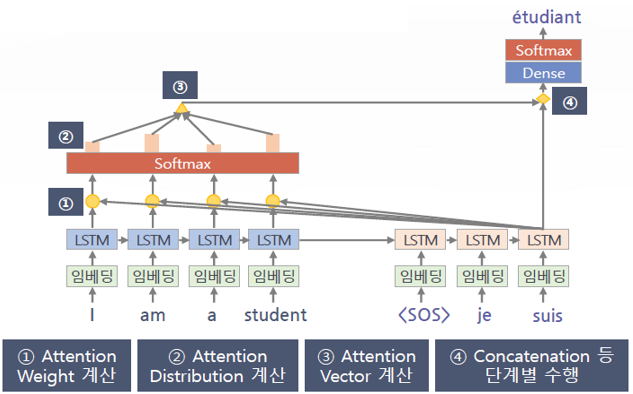

In [17]:
from tensorflow.keras.layers import Attention, Concatenate

# 인코더 LSTM구현
ENC_IN = Input(shape=(4, alpha_total_size))

# 윗출력, state_c, state_h
ENC_OUT,  state_h, state_c = LSTM(
                    units=MY_HIDDEN,
                    return_sequences=True,     
                    return_state=True,
            )(ENC_IN)
# 인코더와 디코더를 연결할 link
link = [state_h, state_c]

# 디코더 구현 : return_sequences=True -위로 올라가는 출력값 사용
DEC_IN = Input(shape=(3, alpha_total_size))
DEC_MID, _, _ = LSTM(units=MY_HIDDEN,
              return_state=True,  
              return_sequences=True)(DEC_IN,
                                     initial_state=link)
# 어텐션 메커니즘(그림①②③)
CONTEXT_VECTOR = Attention()([DEC_MID, ENC_OUT])

# 컨텍스트벡터와 디코더LSTM출력을 결합
CONTEXT_AND_LSTM_OUT = Concatenate()([CONTEXT_VECTOR, DEC_MID])

# 최종 출력층
OUT = Dense(units=alpha_total_size,
               activation='softmax')(CONTEXT_AND_LSTM_OUT)

# 모델
model = Model(inputs=[ENC_IN, DEC_IN],
             outputs=OUT)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 4, 171)]     0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 3, 171)]     0           []                               
                                                                                                  
 lstm_6 (LSTM)                  [(None, 4, 128),     153600      ['input_7[0][0]']                
                                 (None, 128),                                                     
                                 (None, 128)]                                                     
                                                                                              

# 8. 학습과정 설정 및 학습하기

In [18]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy']
)
start = time()
# from tensorflow.keras.callbacks import EarlyStopping
# earlyStopping = EarlyStopping(monitor='loss',patience=50)
hist = model.fit([X_enc, X_dec], Y_dec,
                epochs=MY_EPOCH,
                verbose=1)
end = time()
print(f'학습시간 :{end-start}')

Epoch 1/500
4/4 [==============================] - 3s 7ms/step - loss: 5.1138 - accuracy: 0.2212
Epoch 2/500
4/4 [==============================] - 0s 8ms/step - loss: 4.9557 - accuracy: 0.3333
Epoch 3/500
4/4 [==============================] - 0s 8ms/step - loss: 4.2368 - accuracy: 0.3333
Epoch 4/500
4/4 [==============================] - 0s 8ms/step - loss: 3.4760 - accuracy: 0.3333
Epoch 5/500
4/4 [==============================] - 0s 8ms/step - loss: 3.4109 - accuracy: 0.3333
Epoch 6/500
4/4 [==============================] - 0s 7ms/step - loss: 3.3693 - accuracy: 0.3333
Epoch 7/500
4/4 [==============================] - 0s 7ms/step - loss: 3.3338 - accuracy: 0.3333
Epoch 8/500
4/4 [==============================] - 0s 7ms/step - loss: 3.3055 - accuracy: 0.3333
Epoch 9/500
4/4 [==============================] - 0s 7ms/step - loss: 3.2791 - accuracy: 0.3333
Epoch 10/500
4/4 [==============================] - 0s 7ms/step - loss: 3.2533 - accuracy: 0.3333
Epoch 11/500
4/4 [===========

4/4 [==============================] - 0s 9ms/step - loss: 0.4805 - accuracy: 0.9667
Epoch 85/500
4/4 [==============================] - 0s 8ms/step - loss: 0.4561 - accuracy: 0.9545
Epoch 86/500
4/4 [==============================] - 0s 7ms/step - loss: 0.4417 - accuracy: 0.9697
Epoch 87/500
4/4 [==============================] - 0s 18ms/step - loss: 0.4207 - accuracy: 0.9727
Epoch 88/500
4/4 [==============================] - 0s 7ms/step - loss: 0.4009 - accuracy: 0.9667
Epoch 89/500
4/4 [==============================] - 0s 7ms/step - loss: 0.3830 - accuracy: 0.9727
Epoch 90/500
4/4 [==============================] - 0s 8ms/step - loss: 0.3664 - accuracy: 0.9758
Epoch 91/500
4/4 [==============================] - 0s 7ms/step - loss: 0.3493 - accuracy: 0.9848
Epoch 92/500
4/4 [==============================] - 0s 7ms/step - loss: 0.3383 - accuracy: 0.9879
Epoch 93/500
4/4 [==============================] - 0s 7ms/step - loss: 0.3190 - accuracy: 0.9818
Epoch 94/500
4/4 [==============

4/4 [==============================] - 0s 7ms/step - loss: 0.0074 - accuracy: 1.0000
Epoch 168/500
4/4 [==============================] - 0s 7ms/step - loss: 0.0074 - accuracy: 1.0000
Epoch 169/500
4/4 [==============================] - 0s 7ms/step - loss: 0.0083 - accuracy: 1.0000
Epoch 170/500
4/4 [==============================] - 0s 7ms/step - loss: 0.0069 - accuracy: 1.0000
Epoch 171/500
4/4 [==============================] - 0s 7ms/step - loss: 0.0081 - accuracy: 1.0000
Epoch 172/500
4/4 [==============================] - 0s 8ms/step - loss: 0.0091 - accuracy: 1.0000
Epoch 173/500
4/4 [==============================] - 0s 8ms/step - loss: 0.0064 - accuracy: 1.0000
Epoch 174/500
4/4 [==============================] - 0s 8ms/step - loss: 0.0064 - accuracy: 1.0000
Epoch 175/500
4/4 [==============================] - 0s 8ms/step - loss: 0.0060 - accuracy: 1.0000
Epoch 176/500
4/4 [==============================] - 0s 7ms/step - loss: 0.0054 - accuracy: 1.0000
Epoch 177/500
4/4 [=====

4/4 [==============================] - 0s 9ms/step - loss: 5.9461e-05 - accuracy: 1.0000
Epoch 249/500
4/4 [==============================] - 0s 8ms/step - loss: 5.6896e-05 - accuracy: 1.0000
Epoch 250/500
4/4 [==============================] - 0s 7ms/step - loss: 5.3654e-05 - accuracy: 1.0000
Epoch 251/500
4/4 [==============================] - 0s 8ms/step - loss: 5.0725e-05 - accuracy: 1.0000
Epoch 252/500
4/4 [==============================] - 0s 7ms/step - loss: 4.8594e-05 - accuracy: 1.0000
Epoch 253/500
4/4 [==============================] - 0s 6ms/step - loss: 4.5414e-05 - accuracy: 1.0000
Epoch 254/500
4/4 [==============================] - 0s 7ms/step - loss: 4.2408e-05 - accuracy: 1.0000
Epoch 255/500
4/4 [==============================] - 0s 7ms/step - loss: 4.0981e-05 - accuracy: 1.0000
Epoch 256/500
4/4 [==============================] - 0s 7ms/step - loss: 3.7378e-05 - accuracy: 1.0000
Epoch 257/500
4/4 [==============================] - 0s 8ms/step - loss: 3.5437e-05 - a

4/4 [==============================] - 0s 7ms/step - loss: 2.5348e-06 - accuracy: 1.0000
Epoch 328/500
4/4 [==============================] - 0s 14ms/step - loss: 2.7487e-06 - accuracy: 1.0000
Epoch 329/500
4/4 [==============================] - 0s 7ms/step - loss: 2.6482e-06 - accuracy: 1.0000
Epoch 330/500
4/4 [==============================] - 0s 7ms/step - loss: 2.3593e-06 - accuracy: 1.0000
Epoch 331/500
4/4 [==============================] - 0s 7ms/step - loss: 2.2892e-06 - accuracy: 1.0000
Epoch 332/500
4/4 [==============================] - 0s 7ms/step - loss: 3.0217e-06 - accuracy: 1.0000
Epoch 333/500
4/4 [==============================] - 0s 7ms/step - loss: 2.6919e-06 - accuracy: 1.0000
Epoch 334/500
4/4 [==============================] - 0s 8ms/step - loss: 2.3791e-06 - accuracy: 1.0000
Epoch 335/500
4/4 [==============================] - 0s 7ms/step - loss: 2.0490e-06 - accuracy: 1.0000
Epoch 336/500
4/4 [==============================] - 0s 8ms/step - loss: 1.9716e-06 - 

4/4 [==============================] - 0s 9ms/step - loss: 6.7985e-07 - accuracy: 1.0000
Epoch 407/500
4/4 [==============================] - 0s 8ms/step - loss: 6.8022e-07 - accuracy: 1.0000
Epoch 408/500
4/4 [==============================] - 0s 6ms/step - loss: 6.7227e-07 - accuracy: 1.0000
Epoch 409/500
4/4 [==============================] - 0s 7ms/step - loss: 6.6793e-07 - accuracy: 1.0000
Epoch 410/500
4/4 [==============================] - 0s 7ms/step - loss: 6.5746e-07 - accuracy: 1.0000
Epoch 411/500
4/4 [==============================] - 0s 7ms/step - loss: 6.5095e-07 - accuracy: 1.0000
Epoch 412/500
4/4 [==============================] - 0s 7ms/step - loss: 6.4734e-07 - accuracy: 1.0000
Epoch 413/500
4/4 [==============================] - 0s 7ms/step - loss: 6.4337e-07 - accuracy: 1.0000
Epoch 414/500
4/4 [==============================] - 0s 7ms/step - loss: 6.3000e-07 - accuracy: 1.0000
Epoch 415/500
4/4 [==============================] - 0s 7ms/step - loss: 6.2820e-07 - a

4/4 [==============================] - 0s 7ms/step - loss: 3.7894e-07 - accuracy: 1.0000
Epoch 486/500
4/4 [==============================] - 0s 7ms/step - loss: 3.7641e-07 - accuracy: 1.0000
Epoch 487/500
4/4 [==============================] - 0s 8ms/step - loss: 3.7497e-07 - accuracy: 1.0000
Epoch 488/500
4/4 [==============================] - 0s 8ms/step - loss: 3.7135e-07 - accuracy: 1.0000
Epoch 489/500
4/4 [==============================] - 0s 7ms/step - loss: 3.7063e-07 - accuracy: 1.0000
Epoch 490/500
4/4 [==============================] - 0s 7ms/step - loss: 3.6919e-07 - accuracy: 1.0000
Epoch 491/500
4/4 [==============================] - 0s 8ms/step - loss: 3.6232e-07 - accuracy: 1.0000
Epoch 492/500
4/4 [==============================] - 0s 7ms/step - loss: 3.6305e-07 - accuracy: 1.0000
Epoch 493/500
4/4 [==============================] - 0s 6ms/step - loss: 3.6196e-07 - accuracy: 1.0000
Epoch 494/500
4/4 [==============================] - 0s 6ms/step - loss: 3.5907e-07 - a

In [19]:
model.save('data/attention.h5')

# ※ 12월 5일

In [20]:
from tensorflow.keras.models import load_model
model = load_model('data/attention.h5')

In [21]:
# 쉬운 문제
easy_test = [['find','PP'],
             ['cold','PP'],
             ['cook','PP'],
             ['food','PP'],
             ['date','PP']]
enc_in, dec_in, enc_out = encoding(easy_test)
enc_in.shape, dec_in.shape

((5, 4, 171), (5, 3, 171))

In [22]:
pred = model.predict([enc_in, dec_in])
pred.shape

1/1 [==============================] - 1s 572ms/step


(5, 3, 171)

In [23]:
# pred[0], len(pred):5
for i in range(len(pred)):
    eng = easy_test[i][0]
    hat = pred[i].argmax(axis=-1)[:-1]
    # kor = alpha[hat[0]] + alpha[hat[1]]
    kor = ''.join([alpha[num] for num in hat])
    print("{}=>{}{}".format(eng,kor,hat)) #pred[i].argmax(axis=-1))

find=>찾다[148  60]
cold=>감기[32 46]
cook=>요리[122  72]
food=>흐리[170  72]
date=>날짜[ 49 146]


In [24]:
alpha[148]

'찾'

In [25]:
# 어려운 문제
hard_test = [['love','PP'],
             ['lvoe','PP'],
             ['loev','PP'],
             ['olve','PP'],
             ['elov','PP'],
             ['evol','PP'],
             ['rave','PP']]
enc_in, dec_in, _ = encoding(hard_test)
enc_in.shape, dec_in.shape

((7, 4, 171), (7, 3, 171))

In [26]:
pred = model.predict([enc_in, dec_in],verbose=0).argmax(axis=-1)
pred

array([[ 96,  66,   1],
       [ 96,  66,   1],
       [ 96,  66,   1],
       [ 96,  66,   1],
       [121, 120,   1],
       [ 75,  66,   1],
       [ 56, 140,   1]], dtype=int64)

In [27]:
for i in range(len(pred)):
    eng = hard_test[i][0]
    kor = ''.join([alpha[num] for num in pred[i]])
    print("{}=>{}{}".format(eng,kor[:-1], pred[i][:-1])) 

love=>사랑[96 66]
lvoe=>사랑[96 66]
loev=>사랑[96 66]
olve=>사랑[96 66]
elov=>왼옥[121 120]
evol=>매랑[75 66]
rave=>농장[ 56 140]
